In [1]:
import pandas as pd
import numpy as np
import pyextremes as pye
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
sns.set()

In [2]:
path_data = "/glade/work/alancelin/EVT_rossbypalooza/data/train/A_tas_lat.41_lon.272_spatial.2_reduce.max.csv"
A_df = pd.read_csv(path_data, index_col=0, parse_dates=False)
# A_df.index = [datetime.datetime(int(time.split("-")[0]), int(time.split("-")[1]), int(time.split("-")[2].split(" ")[0])) for time in A_df.index]
A_df.index = [np.datetime64(time) for time in A_df.index]
from tqdm.notebook import trange
A_df.index = [pd.to_datetime(A_df.index[i]) for i in trange(len(A_df.index))]
# set name of index
A_df.index.name = "time"
A_df

  0%|          | 0/763357 [00:00<?, ?it/s]

,tas
time,
0011-01-01 00:00:00,275.69670
0011-01-02 00:00:00,273.68964
0011-01-03 00:00:00,271.51093
0011-01-04 00:00:00,267.61884
0011-01-05 00:00:00,268.49182
...,...
2100-12-27 00:00:00,272.17240
2100-12-28 00:00:00,274.71240
2100-12-29 00:00:00,276.67300


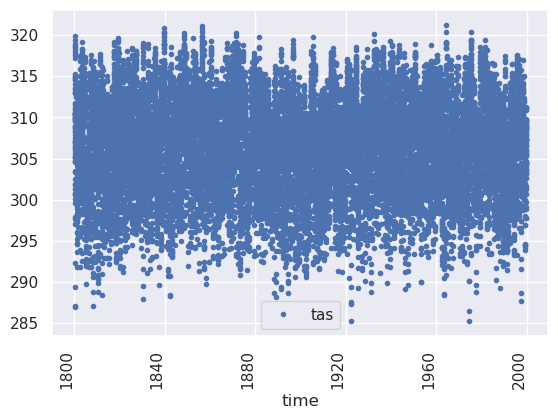

In [4]:
def select_months(df, months):
    df = df.loc[[time.month in months for time in df.index]]
    return df

def select_years(df, years):
    df = df.loc[[time.year in years for time in df.index]]
    return df

A_df = select_months(A_df, [6, 7, 8])
A_df_sub = select_years(A_df, range(1800, 2000))

A_df_sub.plot(marker='o', linestyle='', markersize=3)
# xlabel in vertical
plt.xticks(rotation=90)
plt.show()

In [5]:
# do a return level plot for the data

series = A_df_sub.tas
series.index = pd.to_datetime(A_df_sub.index)
# set a arbitrary time index for the series
# series.index = pd.date_range(start='1/1/2000', periods=len(series), freq='s')

from pyextremes import EVA
model = EVA(series)

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='time', ylabel='tas'>)

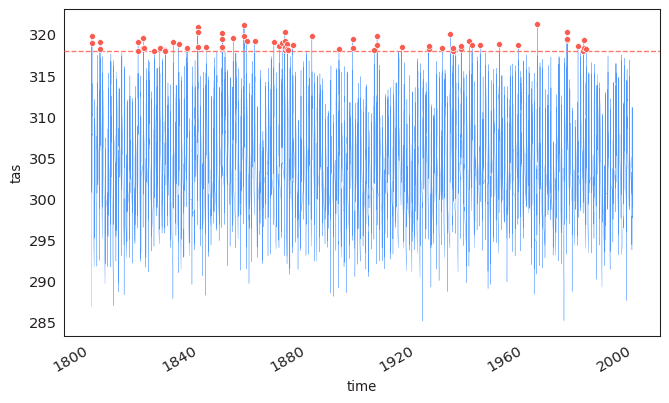

In [6]:
#select r, size of cluster
r="96H"


model.get_extremes(method="POT", threshold=318, r=r)
model.plot_extremes()

<Axes: xlabel='Threshold', ylabel='Mean excess'>

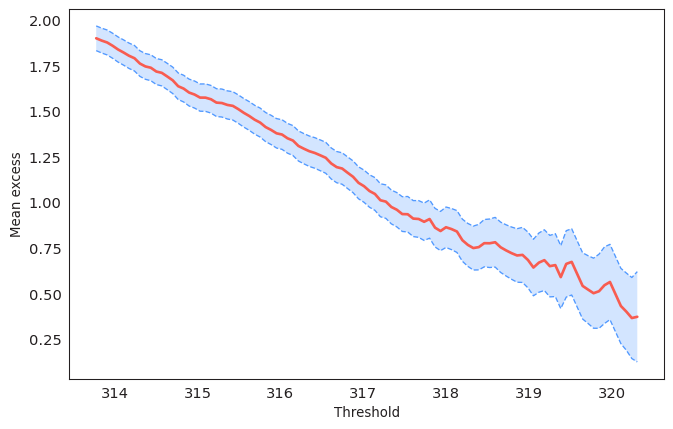

In [7]:
from pyextremes import plot_mean_residual_life
plot_mean_residual_life(series)

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

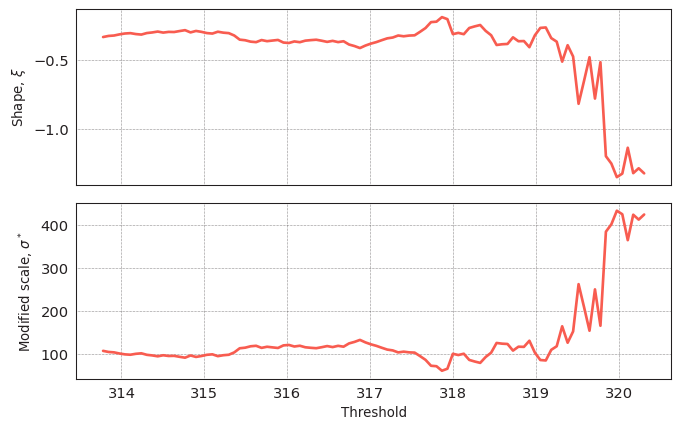

In [8]:
from pyextremes import plot_parameter_stability

plot_parameter_stability(series, r=r)

From that plot, it seems that I would want to choose the threshold around 318.

<Axes: xlabel='Threshold', ylabel='Return value'>

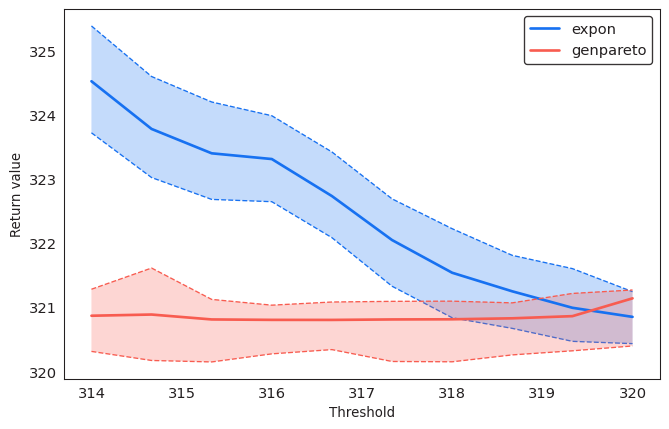

In [9]:
from pyextremes import plot_return_value_stability

plot_return_value_stability(
    series,
    return_period=100,
    thresholds=np.linspace(314, 320, 10),
    alpha=0.95,
    r=r,
)

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

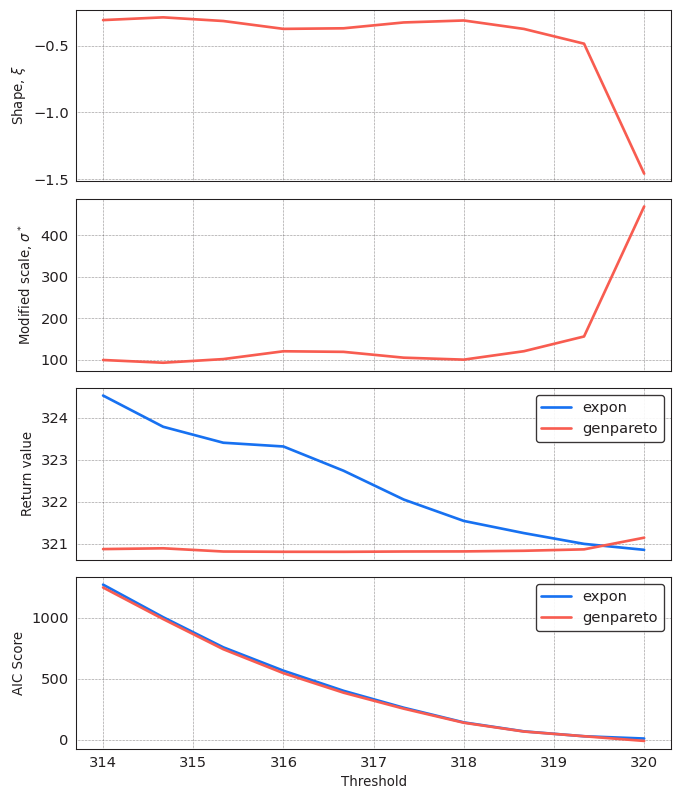

In [10]:
from pyextremes import plot_threshold_stability
plot_threshold_stability(
    series,
    return_period=100,
    thresholds=np.linspace(314, 320, 10),
    r=r,
)

In [11]:
model = EVA(series)
threshold = 316
r = "24H"
model.get_extremes(method="POT", threshold=threshold, r=r)
model.fit_model()
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                           tas      Size:                              18,400
Start:                          June 1800      End:                          August 1999
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                280      Extraction method:                    POT
Type:                                high      Threshold:                            316
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [12]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value    lower ci    upper ci
return period                                      
1.0              316.600571  316.528041  316.692372
2.0              317.651470  317.480001  317.852279
5.0              318.746863  318.515732  318.998041
10.0             319.398518  319.131679  319.651284
25.0             320.077765  319.709511  320.351823
50.0             320.481853  320.026701  320.787768
100.0            320.810774  320.252277  321.180716
250.0            321.153622  320.474653  321.617621
500.0            321.357584  320.597431  321.898489
1000.0           321.523606  320.685193  322.156321


In [72]:
extreme_values_sorted = A_df.tas.loc[A_df.tas > threshold].sort_values(ascending=False)
all_values = A_df.tas
nb_extreme_values = len(extreme_values_sorted)
nb_values = len(all_values)
# # take a subset of sorted values for the return period calculation
# np.random.seed(42)
# n = 280
# indexes = np.random.choice(sorted.index, n, replace=False)
# sorted = sorted.iloc[indexes]

extremes_rate = nb_extreme_values / (nb_values / 92.) # 365.2425)
alpha = 0 #20
beta = 0
exceedance_probability = (np.arange(1, nb_extreme_values + 1) - alpha) / (nb_extreme_values + 1 - alpha - beta) 
return_periods = 1 / (exceedance_probability * extremes_rate)
#    # Calculate exceedance probabilities
#     exceedance_probability = (ranks - alpha) / (len(extremes) + 1 - alpha - beta)

#     # Calculate return periods
#     return_periods = 1 / exceedance_probability / extremes_rate


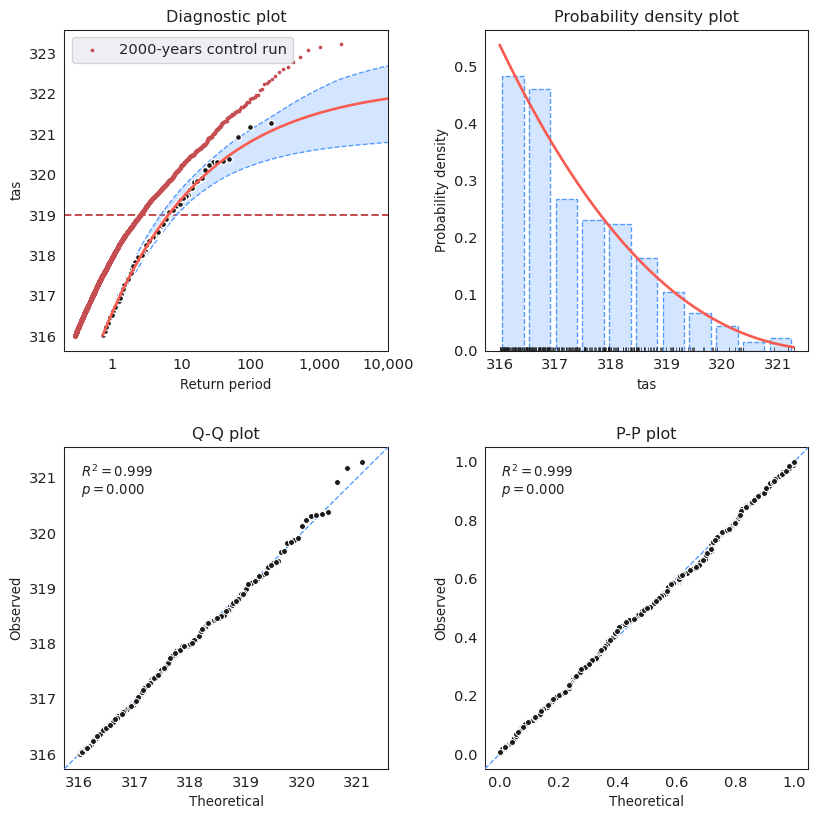

In [74]:
fig, axs = model.plot_diagnostic(alpha=0.95, figsize=(10, 10), return_period=np.logspace(-1, 4, 1000))
axs[0].set_title("Diagnostic plot")
# plot a straight line at 319
axs[0].axhline(y=319, color='r', linestyle='--')
axs[0].set_xlim(0.20, 10000)
axs[0].scatter(return_periods, extreme_values_sorted, color='r', s=3, alpha=1, label="2000-years control run")
axs[0].legend()

In [55]:
np.logspace(0, 4, 10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

In [39]:
model.

{'threshold': 316, 'r': Timedelta('1 days 00:00:00')}

In [ ]:
from pyextremes.extremes import get_return_periods